In [169]:
import pandas as pd 
import numpy as np 
import nfl_data_py as nfl 
from IPython.display import display, HTML

import matplotlib.pyplot as plt

import winsound


In [170]:
plays = nfl.import_pbp_data([2021, 2022, 2023])

2021 done.
2022 done.
2023 done.
Downcasting floats.


In [171]:
#Select the fields that I am interested in using for predicting/feature engineering
fields = ['play_type_nfl', 'play_type'
            , 'week'
              , 'half_seconds_remaining', 'game_seconds_remaining', 'game_half'
              , 'play_id', 'drive', 'game_id'
              , 'posteam', 'defteam'
              , 'yardline_100'
              , 'season_type', 'posteam_type'
              , 'down', 'goal_to_go', 'ydstogo'
              , 'ydsnet', 'yards_gained', 'shotgun', 'no_huddle'
              , 'pass', 'rush', 'first_down', 'touchdown', 'td_team'
              , 'posteam_score', 'defteam_score', 'score_differential'
              , 'game_date', 'home_team', 'away_team'
              , 'total_home_score', 'total_away_score'
              , 'home_timeouts_remaining', 'away_timeouts_remaining'
              , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining'
              , 'penalty_team', 'penalty_yards', 'penalty_type', 'penalty'
              , 'air_yards', 'yards_after_catch', 'incomplete_pass', 'complete_pass', 'passing_yards'
              , 'rush_attempt', 'pass_attempt', 'sack', 'qb_hit'
              , 'pass_touchdown', 'rush_touchdown', 'field_goal_attempt'
              , 'interception', 'fumble_forced', 'fumble_not_forced', 'fumble']

sub_plays = plays.loc[(plays['play_deleted'] == 0) & (plays['play_type'].notna()), fields]

Next I want to create a series of play sequence IDs. I want to know the following: 

* play_seq_game: How many plays have been run in the game (excluding kickoffs, penalties, timeouts)
* play_seq_drive: What number play is this in this drive 
* play_seq_posteam: What number of play is this for the posessing team 
* pass_seq_posteam: How many pass plays have been run so far by the possessing team 
* rush_seq_posteam: How many rush plays 
* shot_seq_posteam: How many plays from shotgun 
* lead_seq_posteam: How many plays has the posessing team had the lead until now 
* fd_seq_posteam: How many first downs as the possessing team gotten 
* sacked_seq_posteam: How many sacks has the possessing team experienced 
* fumble_seq_posteam: How many fumbles has the posessing team experienced 
* int_seq_posteam: How many interceptions has the possessing team experienced
* qbhit_seq_posteam: 
* pental_seq_posteam: 


In [172]:
excl_pt = ['kickoff', 'no_play', 'extra_point', 'qb_kneel', 'qb_spike']

seq_config = {
    'play_seq_game': {
        'filters': lambda x: x['play_type'] not in excl_pt
        , 'sort_col': ['game_id', 'game_half', 'game_seconds_remaining']
        , 'sort_orders': [True, True, False]
        , 'grouper': ['game_id']
    }
    , 'play_seq_drive': {
        'filters': lambda x: x['play_type'] not in excl_pt
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'drive']
    } 
    , 'play_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'pass_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['pass'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'rush_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['rush'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'shot_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['shotgun'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'lead_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['score_differential'] > 0)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'fd_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['first_down'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'sacked_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['sack'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'fumble_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['fumble'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'int_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['interception'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
}

join_col = ['game_id', 'game_half', 'game_seconds_remaining', 'play_id', 'drive']

old_keys = []

for key, sub in seq_config.items(): 
    if key in sub_plays.columns: 
        print(f'{key} already exists')
        continue
    
    df = sub_plays[sub_plays.apply(sub['filters'], axis = 1)].drop(columns = old_keys)

    df_sorted = df.sort_values(sub['sort_col']
                               , ascending = sub['sort_orders'])
    
    df_sorted[key] = df_sorted.groupby(sub['grouper']).cumcount() + 1

    keepers = join_col + [key]

    right = df_sorted.loc[:,keepers]

    sub_plays = sub_plays.merge(right
                                , on = join_col
                                , how = 'left')
    
    old_keys = old_keys + [key]

In [173]:
seq_fix = ['pass_seq_posteam', 'rush_seq_posteam', 'shot_seq_posteam'
           , 'lead_seq_posteam', 'fd_seq_posteam', 'sacked_seq_posteam'
           , 'fumble_seq_posteam', 'int_seq_posteam']

for col in seq_fix: 
    print(f'{col}_shift')
    sub_plays[f'{col}_shift'] = (
    sub_plays.groupby(['game_id', 'posteam'], group_keys = False)[col]
        .apply(lambda group: group.ffill().fillna(0).shift(1).fillna(0))
        )
    
sub_plays['last_play'] = (
    sub_plays.loc[~sub_plays['play_type'].isin(excl_pt), ['game_id', 'posteam', 'play_type']]
    .groupby(['game_id', 'posteam'])['play_type']
    .shift(1)
)

pass_seq_posteam_shift
rush_seq_posteam_shift
shot_seq_posteam_shift
lead_seq_posteam_shift
fd_seq_posteam_shift
sacked_seq_posteam_shift
fumble_seq_posteam_shift
int_seq_posteam_shift


In [174]:
excl_pt = ['kickoff', 'no_play', 'extra_point']
filt = lambda x: (x['play_type'] not in excl_pt)

print(f'Original PBP length is {len(sub_plays)}')
sub_plays_filt = sub_plays[sub_plays.apply(filt, axis = 1)]
print(f'Included PBP length is {len(sub_plays_filt)}')

sub_plays_filt.loc[:, 'target'] = sub_plays_filt.apply(
    lambda x: 1 if (x['first_down'] == 1) 
              or ((x['touchdown'] == 1) and (x['posteam'] == x['td_team'])) 
              else 0, 
    axis=1
)

y = sub_plays_filt.loc[:, 'target'] 
# x = sub_plays_filt.loc[:, ['game_half', 'last_play'
#                            , 'game_seconds_remaining', 'yardline_100', 'score_differential'


#                            , 'play_seq_game', 'play_seq_drive', 'play_seq_posteam', 'pass_seq_posteam', 'rush_seq_posteam', 'shot_seq_posteam', 'lead_seq_posteam', 'fd_seq_posteam', 'sacked_seq_posteam', 'fumble_seq_posteam', 'int_seq_posteam' 
                           
#                            , 'goal_to_go', 'down', 'ydstogo'
                           
#                            , 'shotgun', 'no_huddle'

#                            , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining'
                           
#                            ,'drive', 'week']]




Original PBP length is 144659
Included PBP length is 118427


C:\Users\chris\AppData\Local\Temp\ipykernel_11020\4160182210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plays_filt.loc[:, 'target'] = sub_plays_filt.apply(


In [175]:
#Data cleaning pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report

x = sub_plays_filt.loc[:, ['shotgun', 'game_half', 'last_play', 'no_huddle'
                           , 'down', 'yardline_100', 'goal_to_go', 'ydstogo'
                           , 'score_differential'
                           , 'play_seq_game', 'play_seq_drive', 'drive'
                           , 'play_seq_posteam'
                           , 'pass_seq_posteam_shift', 'rush_seq_posteam_shift', 'shot_seq_posteam_shift'
                           , 'lead_seq_posteam_shift', 'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift', 'int_seq_posteam_shift' 
                           , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']]

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

print(f'Categorical cols: {categorical_cols}') 
print(f'Numeric cols: {numerical_cols}')

# Preprocessing for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Define the Random Forest pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42
                                          , n_estimators = 100
                                          , max_depth = 8
                                          , max_features = 'sqrt'
                                          , bootstrap = True))
])

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(x_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


Categorical cols: Index(['game_half', 'last_play'], dtype='object')
Numeric cols: Index(['shotgun', 'no_huddle', 'down', 'yardline_100', 'goal_to_go', 'ydstogo',
       'score_differential', 'play_seq_game', 'play_seq_drive', 'drive',
       'play_seq_posteam', 'pass_seq_posteam_shift', 'rush_seq_posteam_shift',
       'shot_seq_posteam_shift', 'lead_seq_posteam_shift',
       'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift',
       'int_seq_posteam_shift', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.77      0.96      0.86     17404
           1       0.66      0.19      0.30      6282

    accuracy                           0.76     23686
   macro avg       0.71      0.58      0.58     23686
weighted avg       0.74      0.76      0.71     23686



__Precision__: True positives / all observations  

__Recall__: True Positives / all observed positives  

__F1__: 2 * ([Precision * Recall] / [Precision + Recall])

__Accuracy__: True positive + True Negative / all observations (% of correctly identified cases) 

Macro avg: The average of the two values in the above column 
Weighted avg: The average of the two values weighted by support in the columns above 

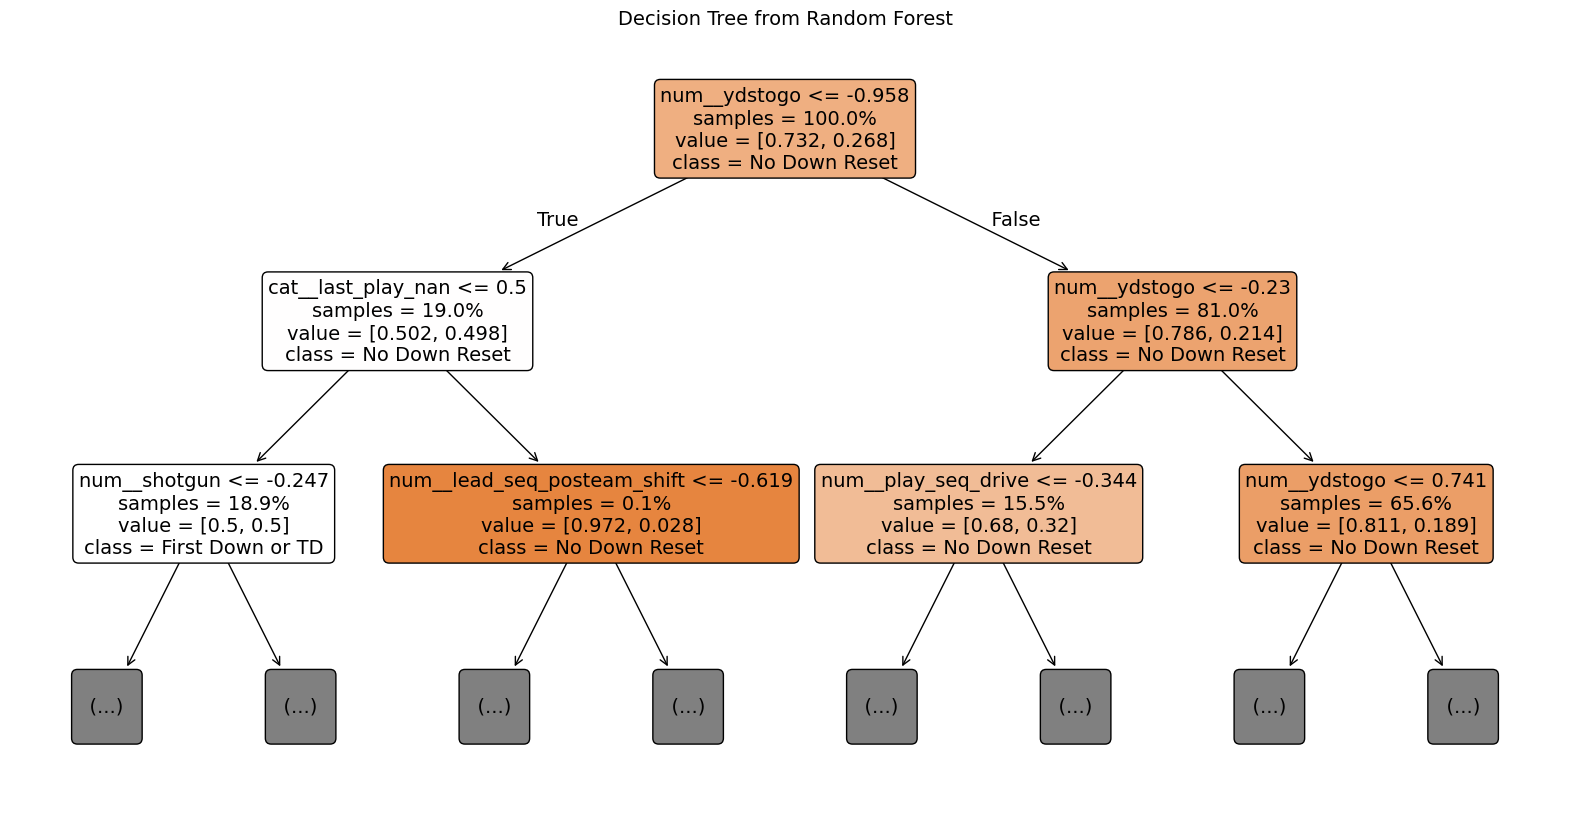

In [176]:
from sklearn.tree import plot_tree

# Extract a single tree from the trained Random Forest model
rf_model = pipeline.named_steps['classifier']
single_tree = rf_model.estimators_[0]  # Get the first tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(single_tree 
          ,impurity = False
          ,max_depth = 2
          ,proportion = True
          ,feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out()
          ,class_names=['No Down Reset', 'First Down or TD']
          ,filled=True, rounded=True, fontsize=14)

plt.title("Decision Tree from Random Forest", fontsize=14)
plt.show()


In [178]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

x = sub_plays_filt.loc[:, ['shotgun', 'game_half', 'last_play', 'no_huddle'
                           , 'down', 'yardline_100', 'goal_to_go', 'ydstogo'
                           , 'score_differential'
                           , 'play_seq_game', 'play_seq_drive', 'drive'
                           , 'play_seq_posteam'
                           , 'pass_seq_posteam_shift', 'rush_seq_posteam_shift', 'shot_seq_posteam_shift'
                           , 'lead_seq_posteam_shift', 'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift', 'int_seq_posteam_shift' 
                           , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']]

x['down'] = x['down'].astype('object')

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

print(f'Categorical cols: {categorical_cols}') 
print(f'Numeric cols: {numerical_cols}')

# Preprocessing for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Define the Random Forest pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': np.array(range(100, 500 + 1, 100)), 
    'classifier__max_depth': np.array(range(20, 30 + 1, 10)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [False, True]
}

# Apply GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=3)
grid_search.fit(x_train, y_train)

# Play a simple ding sound when done
winsound.Beep(2000, 1500)  # Frequency 1000 Hz for 500 milliseconds

Categorical cols: Index(['game_half', 'last_play', 'down'], dtype='object')
Numeric cols: Index(['shotgun', 'no_huddle', 'yardline_100', 'goal_to_go', 'ydstogo',
       'score_differential', 'play_seq_game', 'play_seq_drive', 'drive',
       'play_seq_posteam', 'pass_seq_posteam_shift', 'rush_seq_posteam_shift',
       'shot_seq_posteam_shift', 'lead_seq_posteam_shift',
       'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift',
       'int_seq_posteam_shift', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining'],
      dtype='object')
Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [179]:
# Print best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", pd.DataFrame.from_dict(best_params, orient='index', columns=['Value']))

Best Parameters:                                Value
classifier__bootstrap          False
classifier__max_depth             30
classifier__max_features        sqrt
classifier__min_samples_split      5
classifier__n_estimators         200


c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The markers list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


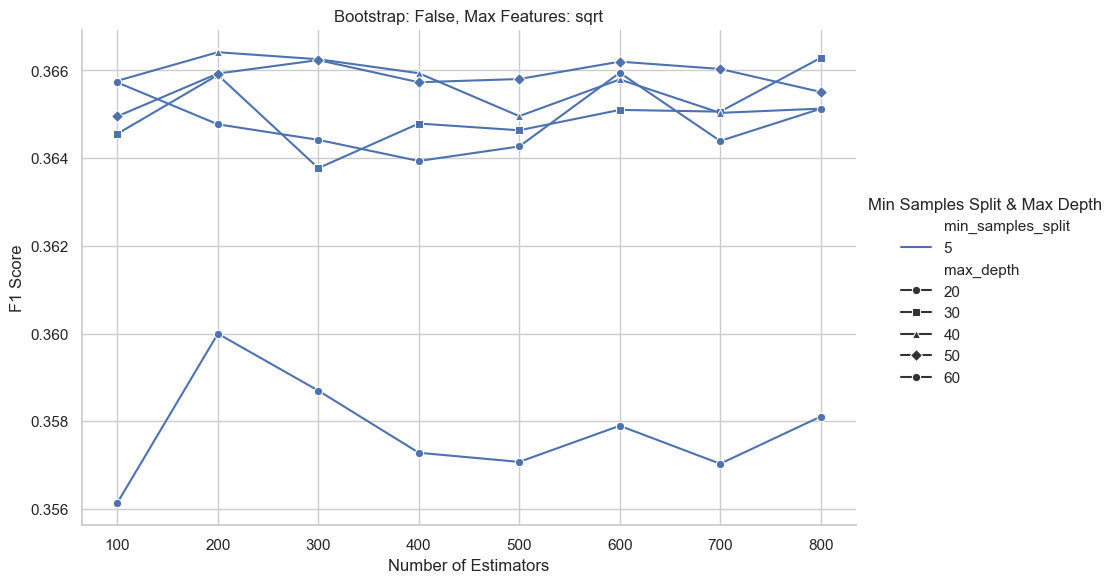

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming grid_search is your fitted grid search object
results = pd.DataFrame(grid_search.cv_results_)

# Rename columns for easier access
plot_results = results.rename(columns = {
    'param_classifier__bootstrap': 'bootstrap',
    'param_classifier__max_depth': 'max_depth',
    'param_classifier__max_features': 'max_feat',
    'param_classifier__min_samples_split': 'min_samples_split',
    'param_classifier__n_estimators': 'n_estimators',
    'mean_test_score': 'f1'
})

# Convert 'max_depth' to integer, ensure other necessary columns are integers
plot_results['max_depth'] = plot_results['max_depth'].astype(int)
plot_results['n_estimators'] = plot_results['n_estimators'].astype(int)
plot_results['min_samples_split'] = plot_results['min_samples_split'].astype('category')

# Ensure 'max_feat' is treated as a categorical variable for faceting
plot_results['max_feat'] = plot_results['max_feat'].astype('category')

# Ensure 'min_samples_split' is treated as a categorical variable for hue
plot_results['min_samples_split'] = plot_results['min_samples_split'].astype('category')

# Create a FacetGrid based on 'bootstrap' and 'max_feat'
g = sns.FacetGrid(plot_results,
                  col='bootstrap',          # Facet by 'bootstrap'
                  row='max_feat',           # Facet by 'max_feat'
                  height=6,                 # Set plot height
                  aspect=1.5)               # Set aspect ratio

# Map the lineplot, specifying the correct x and y values, and grouping by 'min_samples_split'
g.map(sns.lineplot,
      'n_estimators',           # X-axis: 'n_estimators' 
      'f1',                      # Y-axis: 'f1' (mean test score)
      hue=plot_results['min_samples_split'],   # Grouping by 'min_samples_split'
      style=plot_results['max_depth'],         # Different line styles for 'max_depth'
      markers=['o', 's', '^', 'D'],  # Use markers for different groups
      dashes=False)              # Disable dashes for lines

# Add labels, titles, and legends
g.set_axis_labels("Number of Estimators", "F1 Score")
g.set_titles("Bootstrap: {col_name}, Max Features: {row_name}")
g.add_legend(title="Min Samples Split & Max Depth")

# Show the plot
plt.show()


In [228]:
x = sub_plays_filt.loc[:, ['shotgun', 'game_half', 'last_play', 'no_huddle'
                           , 'down', 'yardline_100', 'goal_to_go', 'ydstogo'
                           , 'score_differential'
                           , 'play_seq_game', 'play_seq_drive', 'drive'
                           , 'play_seq_posteam'
                           , 'pass_seq_posteam_shift', 'rush_seq_posteam_shift', 'shot_seq_posteam_shift'
                           , 'lead_seq_posteam_shift', 'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift', 'int_seq_posteam_shift' 
                           , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']]

x['down'] = x['down'].astype('object')

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

print(f'Categorical cols: {categorical_cols}') 
print(f'Numeric cols: {numerical_cols}')

# Preprocessing for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Define the Random Forest pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': np.array(range(100, 800 + 1, 100)), 
    'classifier__max_depth': np.array(range(20, 60 + 1, 10)),
    'classifier__min_samples_split': [5],
    'classifier__max_features': ['sqrt'],
    'classifier__bootstrap': [False]
}

# Apply GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=3)
grid_search.fit(x_train, y_train)

# Play a simple ding sound when done
winsound.Beep(2000, 1500)  # Frequency 1000 Hz for 500 milliseconds

Categorical cols: Index(['game_half', 'last_play', 'down'], dtype='object')
Numeric cols: Index(['shotgun', 'no_huddle', 'yardline_100', 'goal_to_go', 'ydstogo',
       'score_differential', 'play_seq_game', 'play_seq_drive', 'drive',
       'play_seq_posteam', 'pass_seq_posteam_shift', 'rush_seq_posteam_shift',
       'shot_seq_posteam_shift', 'lead_seq_posteam_shift',
       'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift',
       'int_seq_posteam_shift', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining'],
      dtype='object')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The markers list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


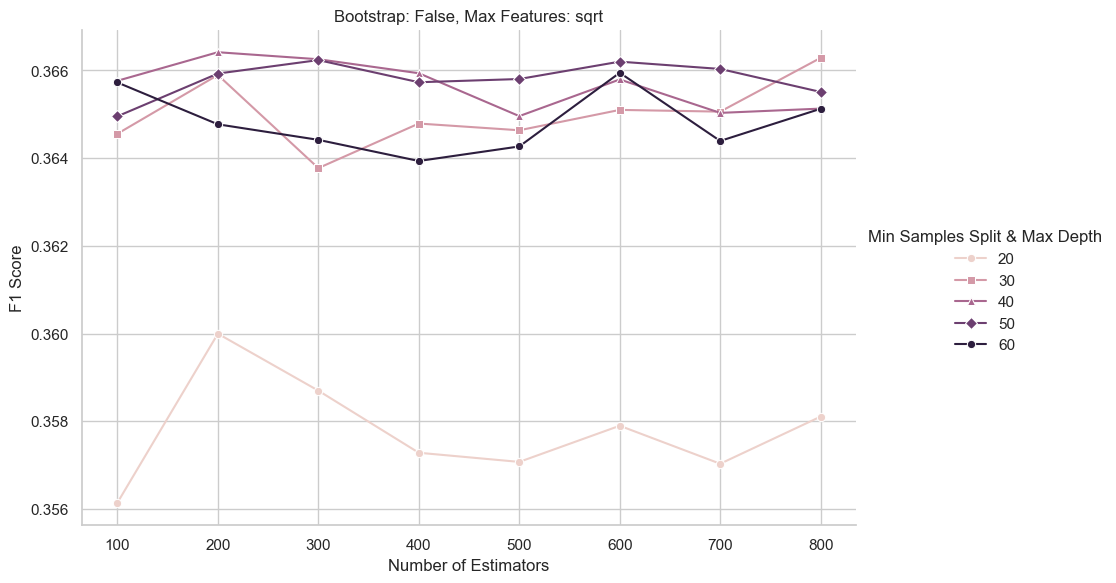

In [230]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming grid_search is your fitted grid search object
results = pd.DataFrame(grid_search.cv_results_)

# Rename columns for easier access
plot_results = results.rename(columns = {
    'param_classifier__bootstrap': 'bootstrap',
    'param_classifier__max_depth': 'max_depth',
    'param_classifier__max_features': 'max_feat',
    'param_classifier__min_samples_split': 'min_samples_split',
    'param_classifier__n_estimators': 'n_estimators',
    'mean_test_score': 'f1'
})

# Convert 'max_depth' to integer, ensure other necessary columns are integers
plot_results['max_depth'] = plot_results['max_depth'].astype(int)
plot_results['n_estimators'] = plot_results['n_estimators'].astype(int)
plot_results['min_samples_split'] = plot_results['min_samples_split'].astype('category')

# Ensure 'max_feat' is treated as a categorical variable for faceting
plot_results['max_feat'] = plot_results['max_feat'].astype('category')

# Ensure 'min_samples_split' is treated as a categorical variable for hue
plot_results['min_samples_split'] = plot_results['min_samples_split'].astype('category')

# Create a FacetGrid based on 'bootstrap' and 'max_feat'
g = sns.FacetGrid(plot_results,
                  col='bootstrap',          # Facet by 'bootstrap'
                  row='max_feat',           # Facet by 'max_feat'
                  height=6,                 # Set plot height
                  aspect=1.5)               # Set aspect ratio

# Map the lineplot, specifying the correct x and y values, and grouping by 'min_samples_split'
g.map(sns.lineplot,
      'n_estimators',           # X-axis: 'n_estimators' 
      'f1',                      # Y-axis: 'f1' (mean test score)
      hue=plot_results['max_depth'],   # Grouping by 'min_samples_split'
      style=plot_results['max_depth'],         # Different line styles for 'max_depth'
      markers=['o', 's', '^', 'D'],  # Use markers for different groups
      dashes=False)              # Disable dashes for lines

# Add labels, titles, and legends
g.set_axis_labels("Number of Estimators", "F1 Score")
g.set_titles("Bootstrap: {col_name}, Max Features: {row_name}")
g.add_legend(title="Min Samples Split & Max Depth")

# Show the plot
plt.show()


0    87029
1    31398
Name: target, dtype: int64
118427


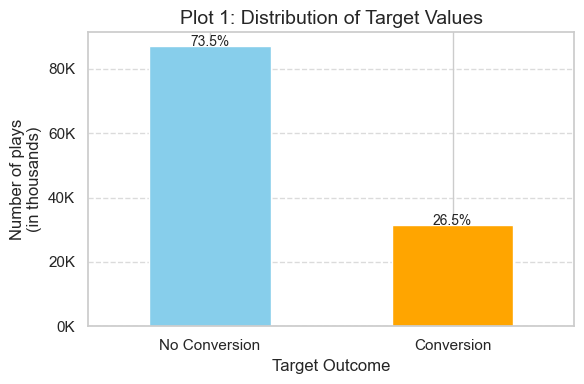

In [273]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Count target values
target_values = sub_plays_filt['target'].value_counts()
print(target_values)
p = sum(target_values)
print(p)

# Calculate percentages for each target value
target_percentages = (target_values / target_values.sum()) * 100

# Update index labels for the plot
target_values.index = ['No Conversion', 'Conversion']

# Create a bar plot with updated labels
plt.figure(figsize=(6, 4))
bars = target_values.plot(kind='bar', color=['skyblue', 'orange'])

# Annotate each bar with its percentage
for bar, percentage in zip(bars.patches, target_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
        bar.get_height() + 0.5,            # Y position (slightly above the bar)
        f"{percentage:.1f}%",             # Text (percentage)
        ha='center', fontsize=10          # Alignment and font size
    )

# Format the y-axis to show thousands with a "K" suffix
formatter = FuncFormatter(lambda x, _: f'{x/1000:.0f}K')
plt.gca().yaxis.set_major_formatter(formatter)

# Add titles and labels
plt.title('Plot 1: Distribution of Target Values', fontsize=14)
plt.xlabel('Target Outcome', fontsize=12)
plt.ylabel('Number of plays\n(in thousands)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


In [240]:
from sklearn.metrics import confusion_matrix

# Simulate predictions (bad model predicting always negative)
y_true = sub_plays_filt['target']  # Actual target values
y_pred = np.zeros_like(y_true)  # Model always predicts '0' (negative class)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()  # For binary classification

# Calculate precision, recall, accuracy, F1 score, sensitivity, and specificity
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
sensitivity = recall  # Sensitivity is the same as recall
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity formula

# Print the calculated metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Precision: 0.0000
Recall (Sensitivity): 0.0000
Accuracy: 0.7349
F1 Score: 0.0000
Sensitivity: 0.0000
Specificity: 1.0000


In [242]:
#Data cleaning pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report

x = sub_plays_filt.loc[:, ['shotgun', 'game_half', 'last_play', 'no_huddle'
                           , 'down', 'yardline_100', 'goal_to_go', 'ydstogo'
                           , 'score_differential'
                           , 'play_seq_game', 'play_seq_drive', 'drive'
                           , 'play_seq_posteam'
                           , 'pass_seq_posteam_shift', 'rush_seq_posteam_shift', 'shot_seq_posteam_shift'
                           , 'lead_seq_posteam_shift', 'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift', 'int_seq_posteam_shift' 
                           , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']]

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

print(f'Categorical cols: {categorical_cols}') 
print(f'Numeric cols: {numerical_cols}')

# Preprocessing for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Define the Random Forest pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42
                                          , n_estimators = 200
                                          , max_depth = 40
                                          , max_features = 'sqrt'
                                          , min_samples_split = 5
                                          , bootstrap = False))
])

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(x_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()  # For binary classification

# Calculate precision, recall, accuracy, F1 score, sensitivity, and specificity
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
sensitivity = recall  # Sensitivity is the same as recall
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity formula

# Print the classification report (precision, recall, F1 score)
print(classification_report(y_test, y_pred))

# Print the manually calculated metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Categorical cols: Index(['game_half', 'last_play'], dtype='object')
Numeric cols: Index(['shotgun', 'no_huddle', 'down', 'yardline_100', 'goal_to_go', 'ydstogo',
       'score_differential', 'play_seq_game', 'play_seq_drive', 'drive',
       'play_seq_posteam', 'pass_seq_posteam_shift', 'rush_seq_posteam_shift',
       'shot_seq_posteam_shift', 'lead_seq_posteam_shift',
       'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift',
       'int_seq_posteam_shift', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     17404
           1       0.58      0.27      0.37      6282

    accuracy                           0.76     23686
   macro avg       0.68      0.60      0.61     23686
weighted avg       0.73      0.76      0.72     23686

              precision    recall  f1-score   support

           0       0.78      0.93      0.85     17404
      

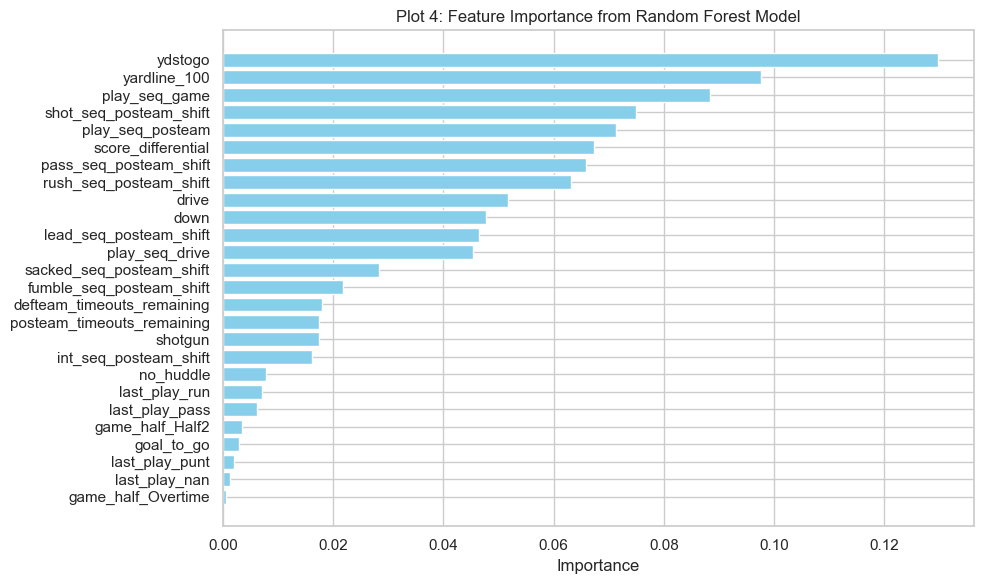

In [276]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the Random Forest model is already fitted in the pipeline
# Extract feature importances from the trained Random Forest model
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Get the feature names from the preprocessor step
# For categorical features, we use one-hot encoded columns, so we get the column names
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

# The one-hot encoded column names from the preprocessor step using get_feature_names_out() method
one_hot_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(one_hot_columns)

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Plot 4: Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

           0       0.78      0.93      0.85     17404
           1       0.58      0.27      0.37      6282

    accuracy                           0.76     23686
   macro avg       0.68      0.60      0.61     23686
weighted avg       0.73      0.76      0.72     23686



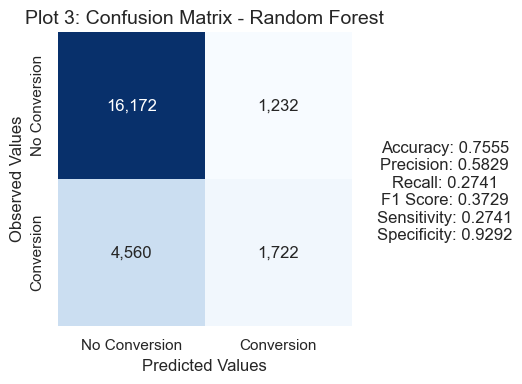

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test and y_pred are already defined
# y_test: Observed Valuess
# y_pred: Predicted Valuess by the model

# Predict on the test data
y_pred = pipeline.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()  # For binary classification

# Calculate precision, recall, accuracy, F1 score, sensitivity, and specificity
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
sensitivity = recall  # Sensitivity is the same as recall
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity formula

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap (without shading)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt=',.0f', cmap='Blues', xticklabels=['No Conversion', 'Conversion'], 
            yticklabels=['No Conversion', 'Conversion'], cbar=False, square=True)

# Add titles and labels
plt.title('Plot 3: Confusion Matrix - Random Forest', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Observed Values', fontsize=12)

# Display evaluation metrics on the plot
metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nSensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}"
plt.gcf().text(.9, .5, metrics_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

# Display the plot
plt.tight_layout()
plt.show()


Precision: 0.0000
Recall (Sensitivity): 0.0000
Accuracy: 0.7349
F1 Score: 0.0000
Sensitivity: 0.0000
Specificity: 1.0000


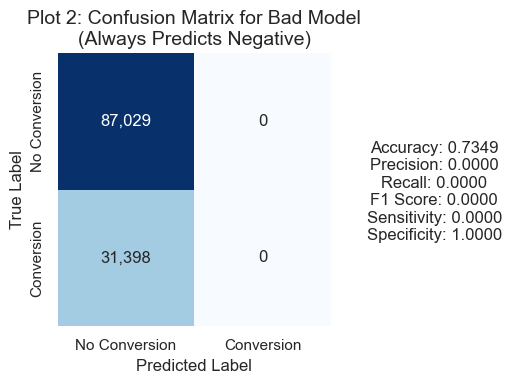

In [274]:
from sklearn.metrics import confusion_matrix

# Simulate predictions (bad model predicting always negative)
y_true = sub_plays_filt['target']  # Actual target values
y_pred_bad = np.zeros_like(y_true)  # Model always predicts '0' (negative class)

# Generate confusion matrix
cm_bad = confusion_matrix(y_true, y_pred_bad)

# Extract values from confusion matrix
TN, FP, FN, TP = cm_bad.ravel()  # For binary classification

# Calculate precision, recall, accuracy, F1 score, sensitivity, and specificity
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
sensitivity = recall  # Sensitivity is the same as recall
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity formula

# Print the calculated metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


# Plot the confusion matrix using seaborn heatmap (without shading)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bad, annot=True, fmt=',.0f', cmap='Blues', xticklabels=['No Conversion', 'Conversion'], 
            yticklabels=['No Conversion', 'Conversion'], cbar=False, square=True)

# Add titles and labels
plt.title('Plot 2: Confusion Matrix for Bad Model\n(Always Predicts Negative)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)


# Display evaluation metrics
metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nSensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}"
plt.gcf().text(.9, .5, metrics_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

# Display the plot
plt.tight_layout()
plt.show()
